# Notebook 4: Experimentation and Tuning

**Objective:** The goal of this notebook is to improve the performance of the Deep RL algorithm. We will create the custom Convolutional Neural Network (CNN) using PyTorch and then use it to train a Reinforcement Learning agent with Stable Baselines3. Then we will study the effect of tuning the hyperparameters of the CNN as well as the PPO policy on the performance of the agent.

In [1]:
# ==============================================================================
# SETUP AND INSTALLATIONS
# ==============================================================================
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Project Path and Create Symlink
PROJECT_PATH = '/content/drive/My Drive/PortfolioProjects/visual-cart-pole-rl'

# Create a symlink for easy access
if not os.path.exists('/project'):
    !ln -sfn '{PROJECT_PATH}' /project
else:
    print("Symlink '/project' already exists.")

# 3. Install System Dependencies
!apt-get update && apt-get install -y swig

# 4. Install Python Libraries
!pip install gymnasium[box2d] stable-baselines3[extra] opencv-python-headless -q

print("✅ Setup complete. Environment is ready.")

Mounted at /content/drive
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,805 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,371 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packag

## Experiment Log 🔬

| Exp. ID | Parameter Changed      | Value              | Timesteps | Peak Mean Reward | Notes                                  |
| :------ | :--------------------- | :----------------- | :-------- | :--------------- | :------------------------------------- |
| 0       | Baseline               | `lr=3e-4`          | 250k      | ~50              | Plateaued early.                       |
| 1       | Learning Rate          | `lr=1e-4`          | 250k      | ~50             | No improvement, also plateaued.        |
| 2       | Wider CNN              | `c_out=64,128,128` | ~82k      | ~50             | Plateaued, much slower FPS.            |
| 3       | **Frame Stacking** | `n_stack=4`        | 250k      | 344 | **Broke the plateau.** |

In [2]:
# --- Import Libraries ---
import gymnasium as gym
import torch
import sys
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage

# Add project to path and import our custom wrapper
if '/project' not in sys.path:
    sys.path.append('/project')
from utils.env_preprocessing import ImageWrapper

print("✅ Setup and imports are complete.")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Setup and imports are complete.


## Functionalizing the Training
We will create a single function, run_experiment, that takes in all the parameters we want to tune. It will handle creating the model, training it, and saving the results with a unique name.

In [3]:
# ==============================================================================
# DEFINE THE CNN ARCHITECTURE FOR THE EXPERIMENT
# ==============================================================================
# This is our baseline CNN architecture
class CustomCNN(BaseFeaturesExtractor):
    """
    A custom CNN with configurable channel dimensions.
    """
    def __init__(
        self,
        observation_space: gym.spaces.Box,
        features_dim: int = 128,
        c1_out: int = 32,
        c2_out: int = 64,
        c3_out: int = 64
    ):
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]

        # Define the CNN layers using the configurable parameters
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, c1_out, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(c1_out, c2_out, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(c2_out, c3_out, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            sample_tensor = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(sample_tensor).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

print("✅ CustomCNN class is defined and ready for the next experiment.")

✅ CustomCNN class is defined and ready for the next experiment.


In [11]:
# ==============================================================================
# CELL: CORE TRAINING FUNCTION (With Frame Stacking Functionality)
# ==============================================================================
from stable_baselines3.common.vec_env import VecFrameStack

def run_experiment(
    experiment_name,
    cnn_class,
    total_timesteps=100000,
    learning_rate=3e-4,
    gamma=0.99,
    cnn_kwargs=None,
    n_stack=1 # NEW: Number of frames to stack
):
    print(f"--- 🔬 Starting Experiment: {experiment_name} ---")

    log_dir = f"/project/logs/{experiment_name}/"
    model_path = f"/project/models/{experiment_name}.zip"

    if cnn_kwargs is None:
        cnn_kwargs = dict(features_dim=128)

    policy_kwargs = dict(
        features_extractor_class=cnn_class,
        features_extractor_kwargs=cnn_kwargs,
    )

    vec_env = make_vec_env('CartPole-v1', n_envs=4, env_kwargs={'render_mode': 'rgb_array'}, wrapper_class=ImageWrapper)
    vec_env = VecTransposeImage(vec_env)

    # NEW: Apply the Frame Stacking wrapper if n_stack > 1
    if n_stack > 1:
        vec_env = VecFrameStack(vec_env, n_stack=n_stack)

    model = PPO("CnnPolicy", vec_env, policy_kwargs=policy_kwargs, learning_rate=learning_rate, gamma=gamma, verbose=1, tensorboard_log=log_dir)

    model.learn(total_timesteps=total_timesteps)
    model.save(model_path)

    print(f"--- ✅ Experiment {experiment_name} Complete ---")
    vec_env.close()
    return model

---
### Experiment 1: Lower Learning Rate 📉

**Hypothesis:** The baseline agent's performance plateaued because the learning rate was too high (`3e-4`), causing the policy updates to be too large and unstable. This prevented the agent from fine-tuning its strategy to achieve a higher score.

**Method:** We will run a new experiment where the only change is a significantly lower learning rate of `1e-4`. We expect this to result in a slower, but more stable and ultimately higher, final reward.

**Expected Outcome:** A higher final `ep_rew_mean` compared to the baseline, and a smoother, more consistent upward trend in the learning curve.

In [ ]:
# ==============================================================================
# EXPERIMENT 1: Lower Learning Rate
# ==============================================================================
run_experiment(
    experiment_name="lr_1e-4",
    cnn_class=CustomCNN,
    total_timesteps=250000,
    learning_rate=1e-4 # Test a slower, more stable learning rate
)

--- 🔬 Starting Experiment: lr_1e-4 ---
Using cpu device


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Logging to /project/logs/lr_1e-4/PPO_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.3     |
|    ep_rew_mean     | 21.3     |
| time/              |          |
|    fps             | 193      |
|    iterations      | 1        |
|    time_elapsed    | 42       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 23          |
|    ep_rew_mean          | 23          |
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 2           |
|    time_elapsed         | 212         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.015599223 |
|    clip_fraction        | 0.0126      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | -0.00521    |
|    learning_rate        | 0.

'/project/logs/lr_1e-4/'

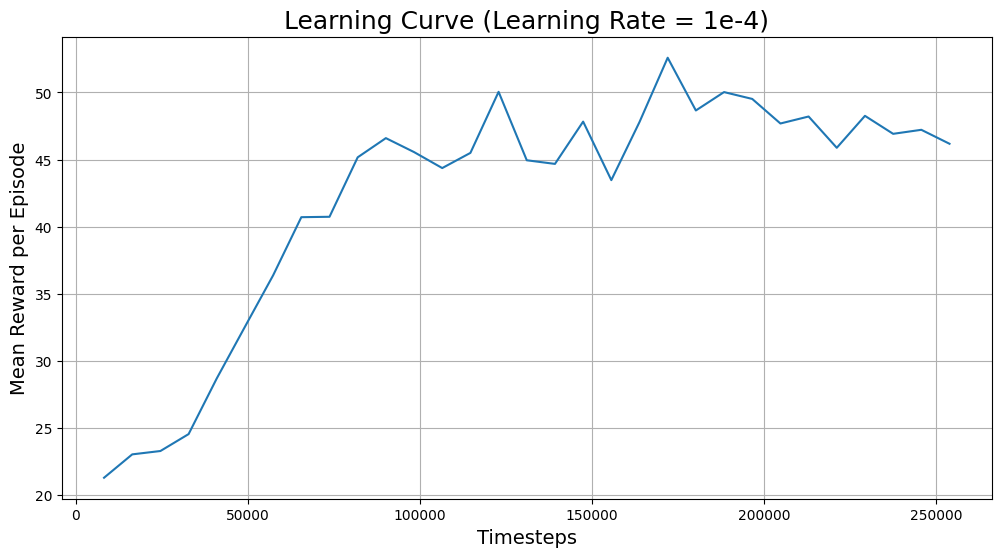

In [7]:
# --- Helper function to parse TensorBoard logs ---
def load_tensorboard_logs(log_dir):
    # Find the latest event file in the directory
    event_file = sorted([os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'tfevents' in f])[-1]

    ea = event_accumulator.EventAccumulator(event_file)
    ea.Reload()

    # The tag for mean reward in SB3 logs is 'rollout/ep_rew_mean'
    df = pd.DataFrame(ea.Scalars('rollout/ep_rew_mean'))
    return df['step'], df['value']

# --- Load the logs for Experiment 1 ---
LOG_DIR = "/project/logs/lr_1e-4_250k/PPO_1"
timesteps, rewards = load_tensorboard_logs(LOG_DIR)

# --- Plot the results ---
plt.figure(figsize=(12, 6))
plt.plot(timesteps, rewards)
plt.title('Learning Curve (Learning Rate = 1e-4)', fontsize=18)
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Mean Reward per Episode', fontsize=14)
plt.grid(True)

# Save the plot with a unique name
plt.savefig('/project/media/learning_curve_lr-1e-4.png')
plt.show()

---
### Experiment 2: Wider CNN Architecture 👁️

**Hypothesis:** The baseline CNN is too narrow and cannot learn a rich enough set of visual features. This "information bottleneck" prevents the PPO algorithm from discovering a more optimal policy, leading to the performance plateau.

**Method:** We will double the number of channels in each convolutional layer of our `CustomCNN` and increase the final feature dimension. This gives the network a greater capacity to learn more varied and complex patterns from the images.

**Expected Outcome:** A significant improvement in the final `ep_rew_mean` compared to the baseline, potentially breaking through the ~50 reward plateau.

In [5]:
# ==============================================================================
# EXPERIMENT 2: Wider CNN
# ==============================================================================

# Define the new, wider CNN architecture
wider_cnn_kwargs = dict(
    features_dim=256,
    c1_out=64,
    c2_out=128,
    c3_out=128
)

run_experiment(
    experiment_name="wider_cnn_250k",
    cnn_class=CustomCNN,
    total_timesteps=250000,
    cnn_kwargs=wider_cnn_kwargs
)

--- 🔬 Starting Experiment: wider_cnn_250k ---
Using cpu device


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Logging to /project/logs/wider_cnn_250k/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | 22.1     |
| time/              |          |
|    fps             | 177      |
|    iterations      | 1        |
|    time_elapsed    | 46       |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 21.1         |
|    ep_rew_mean          | 21.1         |
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 2            |
|    time_elapsed         | 405          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0058497014 |
|    clip_fraction        | 0.00708      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.688       |
|    explain

KeyboardInterrupt: 

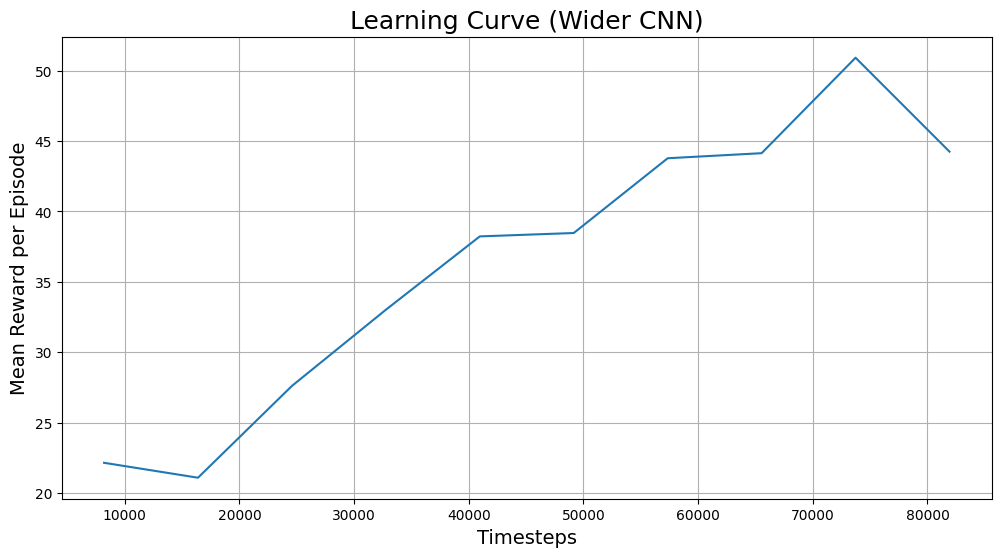

In [8]:
# --- Load the logs for Experiment 2 ---
LOG_DIR = "/project/logs/wider_cnn_250k/PPO_1" # Update if your folder is different
timesteps, rewards = load_tensorboard_logs(LOG_DIR)

# --- Plot the results ---
plt.figure(figsize=(12, 6))
plt.plot(timesteps, rewards)
plt.title('Learning Curve (Wider CNN)', fontsize=18)
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Mean Reward per Episode', fontsize=14)
plt.grid(True)

# Save the plot with a unique name
plt.savefig('/project/media/learning_curve_wider_cnn.png')
plt.show()

---
### Experiment 3: Frame Stacking (Adding a Sense of Motion)

**Hypothesis:** The agent's performance is fundamentally limited because it is "state-blind." From a single image, it can see the pole's position, but it has no direct way to know its **velocity** or **acceleration**. This lack of temporal information prevents it from developing a proactive, stable control policy.

**Method:** We will use a wrapper from Stable Baselines3 called `VecFrameStack`. This wrapper will automatically stack the last **4 consecutive frames** together and feed them to the agent as a single observation. This provides the network with a short history of movement, allowing it to learn temporal features like velocity.

**Expected Outcome:** This should be our most impactful experiment. We expect the agent to finally break through the performance plateau and achieve a significantly higher score, as it can now make decisions based on the dynamics of the system.

In [12]:
# ==============================================================================
# EXPERIMENT 3: Frame Stacking
# ==============================================================================
model_frame_stack = run_experiment(
    experiment_name="frame_stack_4_250k",
    cnn_class=CustomCNN,
    total_timesteps=250000,
    n_stack=4 # Tell the function to stack 4 frames
)

--- 🔬 Starting Experiment: frame_stack_4_250k ---
Using cpu device
Logging to /project/logs/frame_stack_4_250k/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | 23.5     |
| time/              |          |
|    fps             | 198      |
|    iterations      | 1        |
|    time_elapsed    | 41       |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 22.7         |
|    ep_rew_mean          | 22.7         |
| time/                   |              |
|    fps                  | 81           |
|    iterations           | 2            |
|    time_elapsed         | 200          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0039550825 |
|    clip_fraction        | 0.00165      |
|    clip_range           |

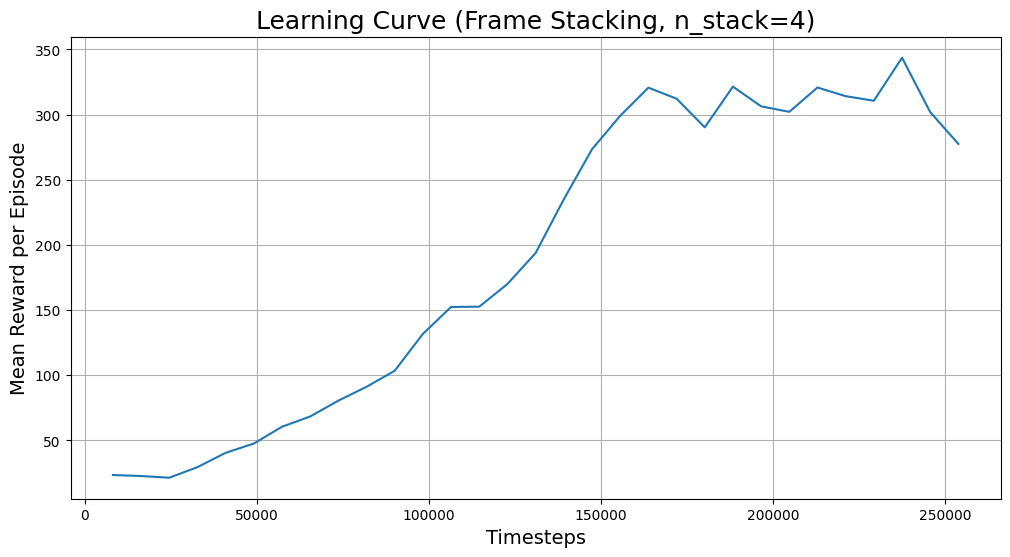

In [13]:
# ==============================================================================
# CELL: PLOT THE FINAL LEARNING CURVE
# ==============================================================================

# --- Load the logs for the frame stacking experiment ---
LOG_DIR = "/project/logs/frame_stack_4_250k/PPO_1"
timesteps, rewards = load_tensorboard_logs(LOG_DIR)

# --- Plot the results ---
plt.figure(figsize=(12, 6))
plt.plot(timesteps, rewards)
plt.title('Learning Curve (Frame Stacking, n_stack=4)', fontsize=18)
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Mean Reward per Episode', fontsize=14)
plt.grid(True)

# Save the plot with a unique name
plt.savefig('/project/media/learning_curve_frame_stack.png')
plt.show()

### Analysis of Experiment 3 (Frame Stacking)

The experiment using frame stacking (`n_stack=4`) was a definitive success, resulting in a peak mean reward of **344**.

This represents a nearly **7x improvement** over the baseline and other experiments, which all plateaued around a score of 50. The agent was able to completely break through the performance wall.

**Conclusion:** The agent's performance was fundamentally limited by its inability to perceive motion (velocity and acceleration) from single, static frames. Providing temporal information by stacking four consecutive frames solved this "state-blindness" and was the critical factor in learning a stable, long-term control policy. The slight performance dip at the very end of training is a common occurrence, often suggesting the learning rate is too high for the final fine-tuning stage.

In [14]:
# ==============================================================================
# CELL: GENERATE GIF OF THE TRAINED AGENT
# ==============================================================================
import imageio
import numpy as np
import random

# --- Model Path ---
MODEL_PATH = "/project/models/frame_stack_4_250k.zip"

# --- Create and sync the environments ---
base_vec_env = make_vec_env('CartPole-v1', n_envs=1, env_kwargs={'render_mode': 'rgb_array'}, wrapper_class=ImageWrapper)
unwrapped_env = gym.make('CartPole-v1', render_mode='rgb_array')

seed = 32
base_vec_env.seed(seed)
wrapped_env = VecFrameStack(base_vec_env, n_stack=4) # Use FrameStack
unwrapped_env.reset(seed=seed)
wrapped_obs = wrapped_env.reset()

# --- Load the trained model ---
model = PPO.load(MODEL_PATH, env=wrapped_env)

# --- Run the episode ---
images = []
total_reward = 0
print("Step | Cart Position | Pole Angle (rad)")
print("------------------------------------------")
for i in range(500):
    action, _ = model.predict(wrapped_obs, deterministic=True)

    wrapped_obs, reward, done, info = wrapped_env.step(action)
    unwrapped_obs, _, _, _, _ = unwrapped_env.step(action[0])

    cart_pos = unwrapped_obs[0]
    pole_angle = unwrapped_obs[2]
    print(f"{i:4d} | {cart_pos:13.4f} | {pole_angle:16.4f}")

    total_reward += reward[0]
    images.append(unwrapped_env.render())

    if done:
        print("\n--- Episode Terminated ---")
        print(f"Final Cart Position: {cart_pos:.4f}")
        print(f"Final Pole Angle: {pole_angle:.4f} rad")
        break

wrapped_env.close()
unwrapped_env.close()

imageio.mimsave('/project/media/final_trained_agent.gif', images, fps=30)
print(f"\n✅ GIF saved. Final reward: {total_reward}")

Wrapping the env in a VecTransposeImage.
Step | Cart Position | Pole Angle (rad)
------------------------------------------
   0 |       -0.0338 |          -0.0126
   1 |       -0.0376 |          -0.0072
   2 |       -0.0452 |           0.0040
   3 |       -0.0568 |           0.0210
   4 |       -0.0722 |           0.0439
   5 |       -0.0838 |           0.0610
   6 |       -0.0915 |           0.0726
   7 |       -0.0953 |           0.0787
   8 |       -0.0952 |           0.0795
   9 |       -0.0912 |           0.0749
  10 |       -0.0833 |           0.0650
  11 |       -0.0716 |           0.0497
  12 |       -0.0560 |           0.0290
  13 |       -0.0365 |           0.0028
  14 |       -0.0209 |          -0.0174
  15 |       -0.0092 |          -0.0318
  16 |       -0.0014 |          -0.0404
  17 |        0.0025 |          -0.0433
  18 |        0.0025 |          -0.0407
  19 |       -0.0014 |          -0.0325
  20 |       -0.0092 |          -0.0186
  21 |       -0.0208 |           0.0

/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(



✅ GIF saved. Final reward: 500.0
